In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/My Drive/Colab Notebooks/Model'

/content/gdrive/My Drive/Colab Notebooks/Model


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

In [4]:
# Data Preparation
train_data_dir = 'MyDataset/train'
validation_data_dir = 'MyDataset/val'
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5816 images belonging to 9 classes.
Found 302 images belonging to 9 classes.


In [5]:
# Model Architecture
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

9406464/9406464 [==============================] - 0s 0us/step


In [6]:
# Freeze layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [8]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
)

Epoch 1/10
 25/181 [===>..........................] - ETA: 16:04 - loss: 0.7174 - accuracy: 0.7763

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


181/181 [==============================] - 1206s 7s/step - loss: 0.3958 - accuracy: 0.8833 - val_loss: 0.2571 - val_accuracy: 0.9306
Epoch 2/10
181/181 [==============================] - 100s 553ms/step - loss: 0.2070 - accuracy: 0.9359 - val_loss: 0.2494 - val_accuracy: 0.9340
Epoch 3/10
181/181 [==============================] - 101s 560ms/step - loss: 0.1763 - accuracy: 0.9436 - val_loss: 0.2754 - val_accuracy: 0.9236
Epoch 4/10
181/181 [==============================] - 98s 544ms/step - loss: 0.1324 - accuracy: 0.9590 - val_loss: 0.2065 - val_accuracy: 0.9375
Epoch 5/10
181/181 [==============================] - 100s 548ms/step - loss: 0.1169 - accuracy: 0.9639 - val_loss: 0.2525 - val_accuracy: 0.9271
Epoch 6/10
181/181 [==============================] - 102s 566ms/step - loss: 0.0942 - accuracy: 0.9703 - val_loss: 0.2843 - val_accuracy: 0.9201
Epoch 7/10
181/181 [==============================] - 100s 551ms/step - loss: 0.0784 - accuracy: 0.9744 - val_loss: 0.2448 - val_accuracy:

In [9]:
model.save('dog_breed_cnn_model_V3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# Load the trained model
loaded_model = load_model('dog_breed_cnn_model_V3.h5')

# Function to preprocess an image for prediction
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array

In [11]:
train_generator.cl

array([0, 0, 0, ..., 8, 8, 8], dtype=int32)

In [13]:
test_image_path = "DogTest/husky2.png"
preprocessed_image = preprocess_image(test_image_path)

# Make a prediction
predictions = loaded_model.predict(preprocessed_image)

# Decode the prediction to get the predicted class
predicted_class = np.argmax(predictions)
print(f"Predicted class index: {predicted_class}")

# Map the predicted class index to the actual class label
class_labels = ['chihuahua','miniature_schnauzer','golden_retriever','rottweiler','great_dane','siberian_husky','pug','pembroke','other']
predicted_label = class_labels[predicted_class]
print(f"Predicted class label: {predicted_label}")

1/1 [==============================] - 2s 2s/step
Predicted class index: 5
Predicted class label: siberian_husky


In [14]:
import pandas as pd

In [15]:
history_df = pd.DataFrame(history.history)

In [16]:
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
5,0.094221,0.970263,0.284261,0.920139
6,0.078399,0.974412,0.244791,0.927083
7,0.068897,0.977351,0.225388,0.937500
8,0.077408,0.972337,0.327873,0.909722
9,0.064763,0.977351,0.326608,0.920139


<Axes: >

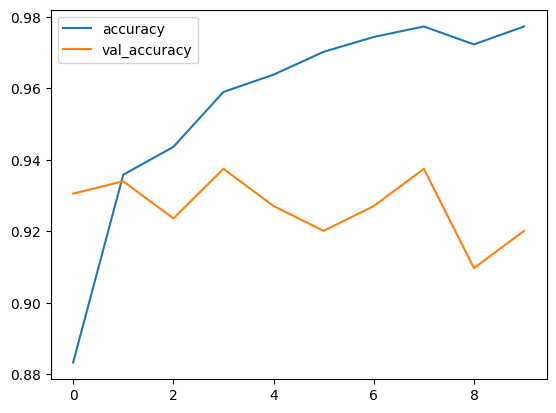

In [17]:
history_df[['accuracy','val_accuracy']].plot()

<Axes: >

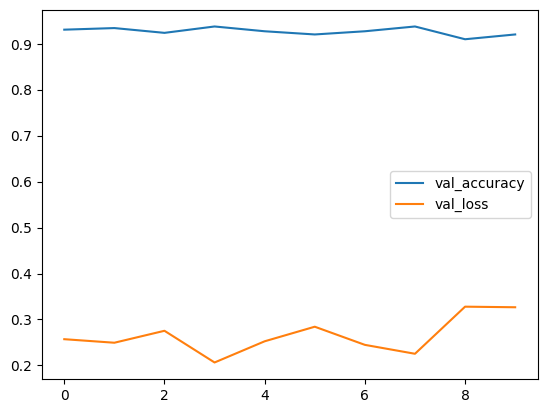

In [19]:
history_df[['val_accuracy','val_loss']].plot()

<Axes: >

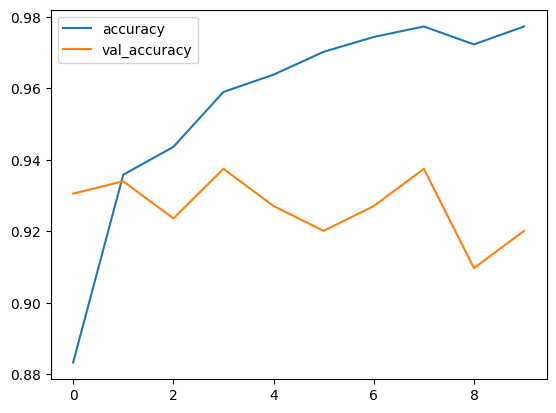

In [21]:
history_df[['accuracy','val_accuracy']].plot()

<Axes: >

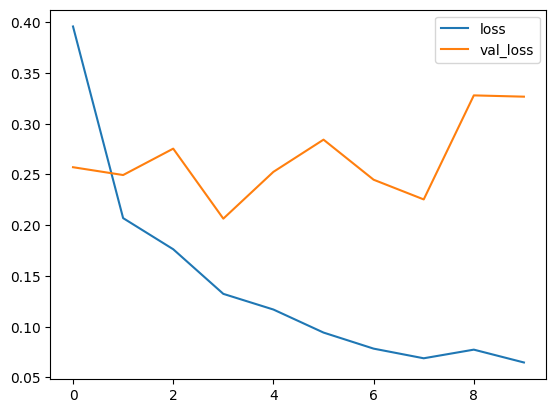

In [20]:
history_df[['loss','val_loss']].plot()